In [1]:
import numpy as np  # For matrix operations and numerical processing
import pandas as pd  # For munging tabular data
import time
import os
from util.preprocess import *  # helper function for classification reports

# setting up SageMaker parameters
import sagemaker
import boto3

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
boto_session = boto3.Session()
region = boto_session.region_name
bucket_name = sagemaker.Session().default_bucket()
bucket_prefix = "emr-mtSample"  # Location in the bucket to store our files
sgmk_session = sagemaker.Session()

sgmk_client = boto_session.client("sagemaker")  ## API for sagemaker
cm_client = boto3.client(service_name='comprehendmedical', use_ssl=True, region_name = 'us-east-1') ## API for comprehend medical

In [3]:
df=pd.read_csv("./data/mtsamples.csv")
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [4]:
df.isnull().sum(axis=0) ## check for missing information

Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64

In [5]:
df=df[df['transcription'].isnull()==False].reset_index()
df.isnull().sum(axis=0) 

index                   0
Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
transcription           0
keywords             1068
dtype: int64

<AxesSubplot: xlabel='count', ylabel='medical_specialty'>

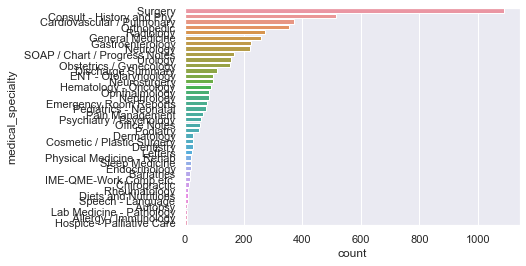

In [6]:
## add patient_id for reference
df['id']=df.index
sns.set(rc={'figure.figsize':(15,10)})
sns.countplot(y='medical_specialty',order=df['medical_specialty'].value_counts().index, data=df)  #df.medical_specialty.value_counts()

In [8]:

df['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

In [31]:
%%time
nSample=150 ## <specify a number to process the medical terms in a batch>. We recommend 20 for time consideration
medical_specialty=' Cardiovascular / Pulmonary'
df_phyList1,patient_ids=subpopulation_comprehend(df, medical_specialty, sampleSize=nSample)

original data shape is  (150, 9)
data shape after removing missing entries is  (150, 9)


100%|██████████| 150/150 [04:38<00:00,  1.86s/it]

CPU times: user 389 ms, sys: 138 ms, total: 527 ms
Wall time: 4min 39s


In [32]:
df_extracted_surg=extractMCbatch(df_phyList1,patient_ids)

## plot the results
topN=20 ## the number for top conditions
threshold_score=0.9 ##the threshold of confidence score

/Users/nihal/Development/aws/util/preprocess.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final=df_final.append(df_ind)
/Users/nihal/Development/aws/util/preprocess.py:71: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_mc = pd.DataFrame({'MEDICAL_CONDITION': pd.Series(medical_conditions), 'Score':pd.Series(scores),'Trait':pd.Series(traits)})
/Users/nihal/Development/aws/util/preprocess.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final=df_final.append(df_ind)
/Users/nihal/Development/aws/util/preprocess.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final=df_final.append(df_in

UnboundLocalError: local variable 'df_mc' referenced before assignment

In [17]:
%%time
nSample=400 ##<specify a number to process the medical terms in a batch >
medical_specialty=' Orthopedic'
df_phyList,patient_ids=subpopulation_comprehend(df, medical_specialty)

original data shape is  (200, 9)
data shape after removing missing entries is  (200, 9)


100%|██████████| 200/200 [07:21<00:00,  2.21s/it]

CPU times: user 2.02 s, sys: 635 ms, total: 2.66 s
Wall time: 7min 21s


In [18]:
## organize into a dataframe
df_extracted_consult=extractMCbatch(df_phyList,patient_ids)
## plot the results
topN=20 ## the number for top conditions
threshold_score=0.9

/Users/nihal/Development/aws/util/preprocess.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final=df_final.append(df_ind)
/Users/nihal/Development/aws/util/preprocess.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final=df_final.append(df_ind)
/Users/nihal/Development/aws/util/preprocess.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final=df_final.append(df_ind)
/Users/nihal/Development/aws/util/preprocess.py:71: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_mc = pd.DataFrame({'MEDICAL_CONDITION': pd.Series(medical_conditions), 'Score':pd.Series(scores),'Trait':pd.Series(traits)

In [19]:
df_extracted_surg.head()

,MEDICAL_CONDITION,Score,Trait,ID
1,Hallux rigidus,0.619677,DIAGNOSIS,172
6,capsule,0.681041,NaN,172
8,cartilage,0.473681,SIGN,172
13,compression,0.583764,SIGN,172
7,degenerative joint disease,0.526174,SIGN,172


In [20]:
df_extracted_consult.head()

,MEDICAL_CONDITION,Score,Trait,ID
61,Alert,0.994968,SIGN,4049
63,Anticipatory guidelines,0.467785,NaN,4049
22,Atraumatic,0.999424,SIGN,4049
35,Clear to auscultation,0.984397,SIGN,4049
38,Good air exchange,0.526437,SIGN,4049


In [21]:
mcList1, df_grp1=retrieve_mcList(df_extracted_surg, 20)

In [22]:
mcList2, df_grp2=retrieve_mcList(df_extracted_consult)

In [23]:
## Label the target column "Label": True--> go to see Surgery specialist, False --> only Consultation
df_grp1['Label']=True # group one is Labeled as True 
df_grp2['Label']=False


df_combined=df_grp1.append(df_grp2) ## append two data frames 
mcLists=list(set(mcList1+mcList2))

df_combined2=df_mc_generator(df_combined,mcLists ,colname_other=['ID',"Label"] )

/var/folders/hj/p6l0b1mn45g2gkngszw4w2lr0000gn/T/ipykernel_97426/2528803323.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined=df_grp1.append(df_grp2) ## append two data frames


In [24]:
df_combined2.to_csv("./data/processed_combined_wide_short.csv",index=False)

In [25]:
df_combined2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 992 entries, 1 to 27
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   992 non-null    int64  
 1   Label                992 non-null    int64  
 2   infection            992 non-null    float64
 3   dysphagia            992 non-null    float64
 4   shortness of breath  992 non-null    float64
 5   cyanosis             992 non-null    float64
 6   stenosis             992 non-null    float64
 7   alert                992 non-null    float64
 8   distress             992 non-null    float64
 9   bleeding             992 non-null    float64
 10  complications        992 non-null    float64
 11  hemostasis           992 non-null    float64
 12  mass                 992 non-null    float64
 13  soft                 992 non-null    float64
 14  fracture             992 non-null    float64
 15  discomfort           992 non-null    floa